In [29]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torchvision.datasets.folder import default_loader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

In [30]:
batch_size = 20
image_size = (256,256)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
workers=4
dataroot = r"C:\Users\kilbo\Documents\GitHub\dsci478k\data"

In [32]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   #                                    transforms.RandomCrop(32, padding=2),
                                   #                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root=dataroot,
                                            transform=transform_ds)
device = torch.device("cuda:0")
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
print(len(train_ds))

7338


In [34]:
real_batch = next(iter(train_dl))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=2, normalize=True).cpu(),(1,2,0)))


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "C:\Users\kilbo\anaconda3\envs\py3.8\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 34, in _pin_memory_loop
    data = pin_memory(data)
  File "C:\Users\kilbo\anaconda3\envs\py3.8\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 58, in pin_memory
    return [pin_memory(sample) for sample in data]
  File "C:\Users\kilbo\anaconda3\envs\py3.8\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 58, in <listcomp>
    return [pin_memory(sample) for sample in data]
  File "C:\Users\kilbo\anaconda3\envs\py3.8\lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 50, in pin_memory
    return data.pin_memory()
RuntimeError: cuda runtime error (999) : unknown error at ..\aten\src\THC\THCCachingHostAllocator.cpp:280


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


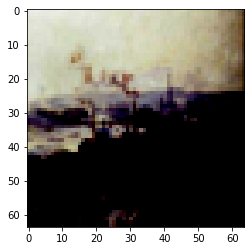

In [5]:
images,label = train_ds[299]

print(images.size())
plt.imshow(np.transpose(images, (1, 2, 0)))


In [6]:

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
train_dl = DeviceDataLoader(train_dl,device)

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [9]:
discriminator = to_device(discriminator,device)

In [10]:
latent_size=150

In [11]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [12]:
xb = torch.rand(batch_size,latent_size,1,1)

torch.Size([20, 3, 64, 64])


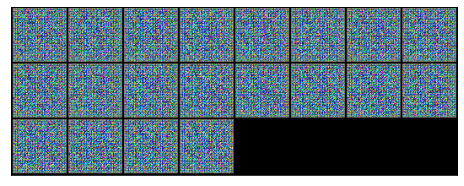

In [13]:
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

#[batchsize,rgb,w,h]

In [14]:
generator = to_device(generator, device)

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


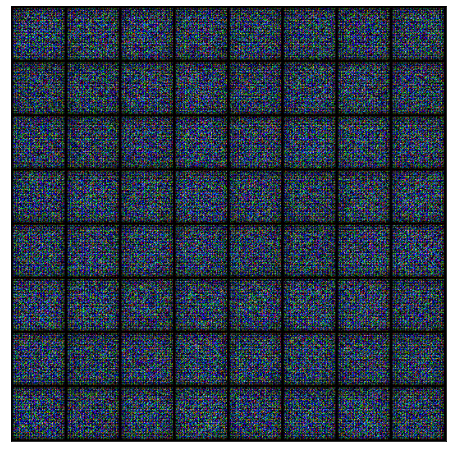

In [20]:
save_samples(0, fixed_latent)

In [21]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [22]:
lr = 0.001
epochs = 150

In [23]:
history = fit(epochs,lr)

  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 0.8973, loss_d: 1.4270, real_score: 0.5296, fake_score: 0.4660
Saving generated-images-0001.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 0.8731, loss_d: 1.0898, real_score: 0.4652, fake_score: 0.1995
Saving generated-images-0002.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 2.4376, loss_d: 1.3179, real_score: 0.6153, fake_score: 0.4491
Saving generated-images-0003.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 1.6447, loss_d: 1.5436, real_score: 0.5788, fake_score: 0.4758
Saving generated-images-0004.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 4.4120, loss_d: 1.3481, real_score: 0.8571, fake_score: 0.6408
Saving generated-images-0005.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 2.1693, loss_d: 0.9761, real_score: 0.6193, fake_score: 0.3329
Saving generated-images-0006.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 2.1475, loss_d: 1.2982, real_score: 0.5805, fake_score: 0.4546
Saving generated-images-0007.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 2.0132, loss_d: 1.0020, real_score: 0.8786, fake_score: 0.5028
Saving generated-images-0008.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 1.5355, loss_d: 0.8571, real_score: 0.6424, fake_score: 0.2885
Saving generated-images-0009.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 2.0141, loss_d: 0.9625, real_score: 0.7947, fake_score: 0.4505
Saving generated-images-0010.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 2.4606, loss_d: 1.5784, real_score: 0.6818, fake_score: 0.5306
Saving generated-images-0011.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 2.5381, loss_d: 1.0796, real_score: 0.5605, fake_score: 0.2975
Saving generated-images-0012.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 5.1585, loss_d: 0.7351, real_score: 0.9605, fake_score: 0.4374
Saving generated-images-0013.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 1.8878, loss_d: 1.0641, real_score: 0.6272, fake_score: 0.3159
Saving generated-images-0014.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 2.1392, loss_d: 1.0212, real_score: 0.8230, fake_score: 0.4757
Saving generated-images-0015.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 2.8900, loss_d: 0.3325, real_score: 0.8023, fake_score: 0.0726
Saving generated-images-0016.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 1.0737, loss_d: 1.2905, real_score: 0.5820, fake_score: 0.2698
Saving generated-images-0017.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 2.2384, loss_d: 0.2924, real_score: 0.8479, fake_score: 0.0938
Saving generated-images-0018.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 0.9727, loss_d: 1.4899, real_score: 0.4043, fake_score: 0.1681
Saving generated-images-0019.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 3.4775, loss_d: 2.1891, real_score: 0.9577, fake_score: 0.8171
Saving generated-images-0020.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 1.3600, loss_d: 0.8764, real_score: 0.5556, fake_score: 0.0240
Saving generated-images-0021.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 2.7421, loss_d: 0.5827, real_score: 0.8308, fake_score: 0.2892
Saving generated-images-0022.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 2.4821, loss_d: 1.5501, real_score: 0.3364, fake_score: 0.0053
Saving generated-images-0023.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 1.6074, loss_d: 1.0618, real_score: 0.5085, fake_score: 0.0913
Saving generated-images-0024.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 4.1275, loss_d: 0.2268, real_score: 0.9401, fake_score: 0.1340
Saving generated-images-0025.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 2.8834, loss_d: 0.5316, real_score: 0.7600, fake_score: 0.1557
Saving generated-images-0026.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 3.8487, loss_d: 1.0070, real_score: 0.9474, fake_score: 0.4818
Saving generated-images-0027.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 3.1047, loss_d: 0.3306, real_score: 0.8502, fake_score: 0.1333
Saving generated-images-0028.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 4.3420, loss_d: 0.1046, real_score: 0.9603, fake_score: 0.0565
Saving generated-images-0029.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 6.3112, loss_d: 0.2559, real_score: 0.9897, fake_score: 0.1882
Saving generated-images-0030.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 2.3868, loss_d: 0.9801, real_score: 0.5847, fake_score: 0.0543
Saving generated-images-0031.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 5.2476, loss_d: 0.3358, real_score: 0.9490, fake_score: 0.1893
Saving generated-images-0032.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 2.5078, loss_d: 0.2113, real_score: 0.8886, fake_score: 0.0651
Saving generated-images-0033.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 1.6748, loss_d: 1.1739, real_score: 0.4557, fake_score: 0.0195
Saving generated-images-0034.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 4.9276, loss_d: 0.4311, real_score: 0.9441, fake_score: 0.2038
Saving generated-images-0035.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 3.9802, loss_d: 0.5890, real_score: 0.7118, fake_score: 0.0985
Saving generated-images-0036.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 8.4344, loss_d: 0.5018, real_score: 0.9811, fake_score: 0.3140
Saving generated-images-0037.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 6.5368, loss_d: 0.3539, real_score: 0.9559, fake_score: 0.1974
Saving generated-images-0038.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 2.7606, loss_d: 0.3607, real_score: 0.7873, fake_score: 0.0386
Saving generated-images-0039.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 5.8983, loss_d: 0.1368, real_score: 0.8895, fake_score: 0.0115
Saving generated-images-0040.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.9243, loss_d: 0.5178, real_score: 0.9946, fake_score: 0.2583
Saving generated-images-0041.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 4.0476, loss_d: 0.5887, real_score: 0.6722, fake_score: 0.0013
Saving generated-images-0042.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 5.9754, loss_d: 0.0182, real_score: 0.9912, fake_score: 0.0092
Saving generated-images-0043.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 4.3984, loss_d: 0.0236, real_score: 0.9926, fake_score: 0.0159
Saving generated-images-0044.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.2901, loss_d: 0.1603, real_score: 0.8997, fake_score: 0.0237
Saving generated-images-0045.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 4.3964, loss_d: 0.2785, real_score: 0.7866, fake_score: 0.0107
Saving generated-images-0046.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.2442, loss_d: 0.1324, real_score: 0.9624, fake_score: 0.0723
Saving generated-images-0047.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 5.4112, loss_d: 0.3844, real_score: 0.9947, fake_score: 0.1722
Saving generated-images-0048.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 3.6615, loss_d: 0.0808, real_score: 0.9378, fake_score: 0.0117
Saving generated-images-0049.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 4.0993, loss_d: 0.1751, real_score: 0.9957, fake_score: 0.1439
Saving generated-images-0050.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 2.9886, loss_d: 0.0563, real_score: 0.9761, fake_score: 0.0278
Saving generated-images-0051.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 6.5967, loss_d: 0.1622, real_score: 0.9395, fake_score: 0.0524
Saving generated-images-0052.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 3.4477, loss_d: 0.4676, real_score: 0.7279, fake_score: 0.0091
Saving generated-images-0053.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 6.2867, loss_d: 0.2313, real_score: 0.9794, fake_score: 0.1390
Saving generated-images-0054.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 6.2745, loss_d: 2.0219, real_score: 0.9993, fake_score: 0.6286
Saving generated-images-0055.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 5.5182, loss_d: 0.3809, real_score: 0.7508, fake_score: 0.0012
Saving generated-images-0056.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 7.4223, loss_d: 0.0155, real_score: 0.9918, fake_score: 0.0071
Saving generated-images-0057.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 1.4121, loss_d: 1.5985, real_score: 0.4368, fake_score: 0.0021
Saving generated-images-0058.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 4.6112, loss_d: 1.0567, real_score: 0.9995, fake_score: 0.3918
Saving generated-images-0059.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 5.7816, loss_d: 0.0713, real_score: 0.9993, fake_score: 0.0643
Saving generated-images-0060.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 6.9023, loss_d: 0.0475, real_score: 0.9990, fake_score: 0.0421
Saving generated-images-0061.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 7.9455, loss_d: 0.1652, real_score: 0.9281, fake_score: 0.0655
Saving generated-images-0062.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 8.4684, loss_d: 0.6227, real_score: 0.9126, fake_score: 0.0964
Saving generated-images-0063.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 7.9242, loss_d: 0.2171, real_score: 0.9014, fake_score: 0.0062
Saving generated-images-0064.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 6.9131, loss_d: 0.0481, real_score: 0.9996, fake_score: 0.0447
Saving generated-images-0065.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 7.3260, loss_d: 0.2585, real_score: 0.9840, fake_score: 0.1517
Saving generated-images-0066.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 6.1566, loss_d: 0.0862, real_score: 0.9895, fake_score: 0.0549
Saving generated-images-0067.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 4.5182, loss_d: 0.0687, real_score: 0.9506, fake_score: 0.0110
Saving generated-images-0068.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 3.8961, loss_d: 0.7677, real_score: 0.9997, fake_score: 0.3472
Saving generated-images-0069.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 5.7577, loss_d: 0.6818, real_score: 0.7039, fake_score: 0.0002
Saving generated-images-0070.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 8.7182, loss_d: 0.2392, real_score: 0.9958, fake_score: 0.1406
Saving generated-images-0071.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 7.7410, loss_d: 0.0280, real_score: 0.9974, fake_score: 0.0222
Saving generated-images-0072.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.9198, loss_d: 0.0910, real_score: 0.9514, fake_score: 0.0289
Saving generated-images-0073.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 6.2905, loss_d: 0.2157, real_score: 0.9580, fake_score: 0.1258
Saving generated-images-0074.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 6.0322, loss_d: 0.1688, real_score: 0.9437, fake_score: 0.0621
Saving generated-images-0075.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 3.7146, loss_d: 0.0288, real_score: 0.9919, fake_score: 0.0196
Saving generated-images-0076.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 9.0725, loss_d: 0.0785, real_score: 0.9447, fake_score: 0.0109
Saving generated-images-0077.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 9.7388, loss_d: 0.0316, real_score: 0.9816, fake_score: 0.0119
Saving generated-images-0078.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 6.2393, loss_d: 0.1033, real_score: 0.9983, fake_score: 0.0556
Saving generated-images-0079.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 10.8605, loss_d: 0.5479, real_score: 0.9966, fake_score: 0.2952
Saving generated-images-0080.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 7.6794, loss_d: 0.0693, real_score: 0.9735, fake_score: 0.0361
Saving generated-images-0081.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 9.1320, loss_d: 0.2061, real_score: 0.8796, fake_score: 0.0304
Saving generated-images-0082.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 6.4735, loss_d: 0.1383, real_score: 0.9736, fake_score: 0.0809
Saving generated-images-0083.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 7.3551, loss_d: 0.0689, real_score: 0.9440, fake_score: 0.0016
Saving generated-images-0084.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 7.7864, loss_d: 0.2212, real_score: 0.9738, fake_score: 0.1065
Saving generated-images-0085.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 5.9619, loss_d: 0.0501, real_score: 0.9636, fake_score: 0.0099
Saving generated-images-0086.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.3339, loss_d: 0.2586, real_score: 0.8596, fake_score: 0.0111
Saving generated-images-0087.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 14.6266, loss_d: 0.0790, real_score: 0.9493, fake_score: 0.0004
Saving generated-images-0088.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 12.5259, loss_d: 0.0409, real_score: 0.9690, fake_score: 0.0007
Saving generated-images-0089.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 3.0949, loss_d: 0.0084, real_score: 1.0000, fake_score: 0.0081
Saving generated-images-0090.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 5.2886, loss_d: 0.2237, real_score: 0.8938, fake_score: 0.0491
Saving generated-images-0091.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 5.6468, loss_d: 0.0369, real_score: 0.9697, fake_score: 0.0024
Saving generated-images-0092.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 10.0398, loss_d: 0.2436, real_score: 0.9956, fake_score: 0.1717
Saving generated-images-0093.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 5.4527, loss_d: 0.0911, real_score: 0.9754, fake_score: 0.0554
Saving generated-images-0094.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 9.3068, loss_d: 0.0432, real_score: 0.9633, fake_score: 0.0009
Saving generated-images-0095.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 5.4505, loss_d: 0.0269, real_score: 0.9843, fake_score: 0.0105
Saving generated-images-0096.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 8.2955, loss_d: 0.2374, real_score: 0.9987, fake_score: 0.1911
Saving generated-images-0097.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 10.7140, loss_d: 0.0125, real_score: 0.9884, fake_score: 0.0005
Saving generated-images-0098.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 10.4475, loss_d: 0.0304, real_score: 0.9784, fake_score: 0.0067
Saving generated-images-0099.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 8.1550, loss_d: 0.0227, real_score: 0.9934, fake_score: 0.0154
Saving generated-images-0100.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 6.1056, loss_d: 0.2701, real_score: 0.8349, fake_score: 0.0004
Saving generated-images-0101.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 8.4653, loss_d: 0.0439, real_score: 0.9622, fake_score: 0.0030
Saving generated-images-0102.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 10.1992, loss_d: 0.1126, real_score: 0.9774, fake_score: 0.0665
Saving generated-images-0103.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 9.0291, loss_d: 0.0141, real_score: 0.9873, fake_score: 0.0012
Saving generated-images-0104.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 5.7693, loss_d: 0.0922, real_score: 0.9980, fake_score: 0.0682
Saving generated-images-0105.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 6.8659, loss_d: 0.0425, real_score: 0.9834, fake_score: 0.0232
Saving generated-images-0106.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 8.0755, loss_d: 0.0038, real_score: 0.9988, fake_score: 0.0025
Saving generated-images-0107.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 5.5746, loss_d: 0.0141, real_score: 0.9999, fake_score: 0.0137
Saving generated-images-0108.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 8.3126, loss_d: 0.0035, real_score: 0.9980, fake_score: 0.0014
Saving generated-images-0109.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 8.4430, loss_d: 0.0640, real_score: 0.9827, fake_score: 0.0375
Saving generated-images-0110.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 7.4604, loss_d: 0.0734, real_score: 0.9688, fake_score: 0.0346
Saving generated-images-0111.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 6.7875, loss_d: 0.0402, real_score: 0.9893, fake_score: 0.0273
Saving generated-images-0112.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 8.4620, loss_d: 0.0117, real_score: 0.9954, fake_score: 0.0068
Saving generated-images-0113.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 8.1853, loss_d: 0.2109, real_score: 0.9992, fake_score: 0.0766
Saving generated-images-0114.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 5.8317, loss_d: 0.1331, real_score: 0.9001, fake_score: 0.0023
Saving generated-images-0115.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 9.6814, loss_d: 0.0130, real_score: 0.9999, fake_score: 0.0123
Saving generated-images-0116.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 11.1759, loss_d: 0.0925, real_score: 0.9397, fake_score: 0.0158
Saving generated-images-0117.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 3.3077, loss_d: 0.0310, real_score: 0.9998, fake_score: 0.0284
Saving generated-images-0118.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 10.3630, loss_d: 0.0425, real_score: 0.9897, fake_score: 0.0288
Saving generated-images-0119.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 7.9834, loss_d: 0.0503, real_score: 0.9736, fake_score: 0.0171
Saving generated-images-0120.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 8.4510, loss_d: 0.0201, real_score: 0.9961, fake_score: 0.0144
Saving generated-images-0121.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 8.3186, loss_d: 0.1223, real_score: 0.9953, fake_score: 0.0512
Saving generated-images-0122.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 4.4229, loss_d: 0.0171, real_score: 0.9998, fake_score: 0.0157
Saving generated-images-0123.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 11.3913, loss_d: 0.0554, real_score: 1.0000, fake_score: 0.0448
Saving generated-images-0124.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 5.9158, loss_d: 0.0533, real_score: 1.0000, fake_score: 0.0451
Saving generated-images-0125.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 12.7505, loss_d: 0.2276, real_score: 0.9973, fake_score: 0.0619
Saving generated-images-0126.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 10.9571, loss_d: 0.0709, real_score: 0.9896, fake_score: 0.0419
Saving generated-images-0127.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 13.1473, loss_d: 0.1432, real_score: 0.9435, fake_score: 0.0392
Saving generated-images-0128.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 9.3743, loss_d: 0.0728, real_score: 0.9389, fake_score: 0.0001
Saving generated-images-0129.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 7.9550, loss_d: 0.1113, real_score: 0.9549, fake_score: 0.0229
Saving generated-images-0130.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 6.1175, loss_d: 0.0807, real_score: 0.9993, fake_score: 0.0628
Saving generated-images-0131.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 5.5159, loss_d: 0.2521, real_score: 0.8848, fake_score: 0.0142
Saving generated-images-0132.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 6.3341, loss_d: 0.0033, real_score: 0.9980, fake_score: 0.0012
Saving generated-images-0133.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 8.8560, loss_d: 0.0211, real_score: 0.9912, fake_score: 0.0110
Saving generated-images-0134.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 6.7566, loss_d: 0.0898, real_score: 0.9919, fake_score: 0.0640
Saving generated-images-0135.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 8.6428, loss_d: 0.0193, real_score: 0.9971, fake_score: 0.0158
Saving generated-images-0136.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 5.2596, loss_d: 0.0423, real_score: 0.9663, fake_score: 0.0010
Saving generated-images-0137.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 9.2258, loss_d: 0.1691, real_score: 1.0000, fake_score: 0.0917
Saving generated-images-0138.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 8.6292, loss_d: 0.3571, real_score: 0.9999, fake_score: 0.2241
Saving generated-images-0139.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 11.1010, loss_d: 0.1188, real_score: 0.9996, fake_score: 0.0705
Saving generated-images-0140.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 7.2806, loss_d: 0.0085, real_score: 0.9968, fake_score: 0.0051
Saving generated-images-0141.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 9.3574, loss_d: 0.5001, real_score: 0.9993, fake_score: 0.2501
Saving generated-images-0142.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 9.2045, loss_d: 0.0142, real_score: 0.9878, fake_score: 0.0007
Saving generated-images-0143.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 15.6769, loss_d: 0.0031, real_score: 0.9976, fake_score: 0.0007
Saving generated-images-0144.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 11.2132, loss_d: 0.0089, real_score: 0.9916, fake_score: 0.0003
Saving generated-images-0145.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 1.8384, loss_d: 1.6456, real_score: 0.4225, fake_score: 0.0005
Saving generated-images-0146.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 10.3020, loss_d: 0.1502, real_score: 0.9992, fake_score: 0.0856
Saving generated-images-0147.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 17.9654, loss_d: 0.7071, real_score: 0.9999, fake_score: 0.3321
Saving generated-images-0148.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 8.4317, loss_d: 0.1282, real_score: 0.9302, fake_score: 0.0088
Saving generated-images-0149.png


  0%|          | 0/367 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 5.6086, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0006
Saving generated-images-0150.png


In [24]:
losses_g, losses_d, real_scores, fake_scores = history

In [25]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

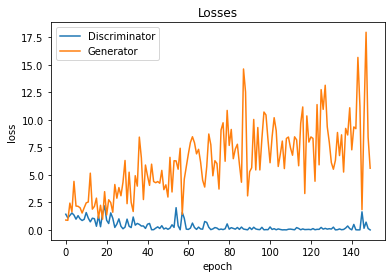

In [26]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

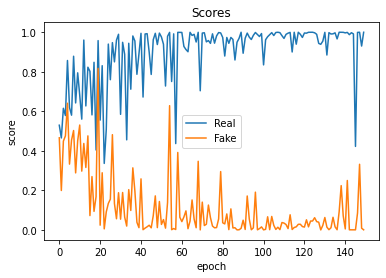

In [27]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [28]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()